With the merged data, now we'll try some typical models for our ML

In [ ]:
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

kf = GroupKFold(n_splits=5)

scoring = {
    "f1": make_scorer(f1_score, pos_label= 1),
    "precision": make_scorer(precision_score, pos_label= 1),
    "recall": make_scorer(recall_score, pos_label=1),
    "precisionF" : make_scorer(precision_score, pos_label=0),
}

search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    scoring=scoring,
    refit='precision'
)


search_rf.fit(X_train, y_train)
print(search_rf.best_params_)
optimal_rf = search_rf.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimat

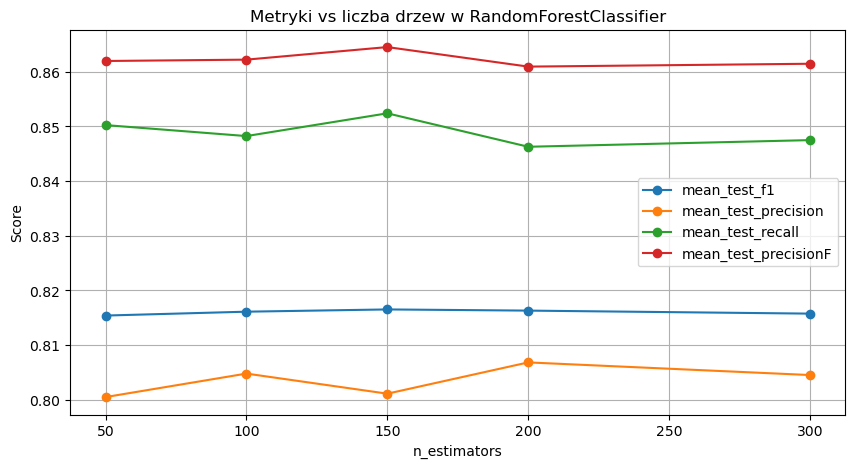

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Wyniki z grid searcha
results = pd.DataFrame(search_rf.cv_results_)  # search = RandomizedSearchCV

# Wybieramy kolumnę parametru, który chcemy analizować (np. n_estimators)
# Dla pipeline byłoby "param_classifier__n_estimators", ale u Ciebie raczej sam model:
results = results.set_index("param_n_estimators")

# Wybieramy metryki, które nas interesują
metrics = ["mean_test_f1", "mean_test_precision", "mean_test_recall", "mean_test_precisionF"]

# Tworzymy podzbiór danych
plot_data = results.groupby("param_n_estimators")[metrics].mean()

# --- Rysowanie wykresu ---
plt.figure(figsize=(10, 5))
for metric in metrics:
    plt.plot(plot_data.index, plot_data[metric], marker='o', label=metric)

plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Metryki vs liczba drzew w RandomForestClassifier")
plt.legend()
plt.grid(True)
plt.show()

Now we will try SVC

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svc = SVC(probability=True)

param_grid = {
    "C": [0.1, 1, 10, 100, 500, 1000,],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],  # tylko dla rbf
    "degree": [2, 3, 4],         # tylko dla poly / linear, dla rbf nie używa się
}

search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid,
    n_iter=20,           # losowe kombinacje
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring=scoring,
    refit="f1"
)

search_svc.fit(X_train, y_train)

print("Najlepsze parametry SVC:", search_svc.best_params_)
optimal_svc = search_svc.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   4.1s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   4.7s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   4.7s
[CV] END ........C=0.1, degree=3, gamma=scale, kernel=linear; total time=   4.6s
[CV] END ...........C=1, degree=3, gamma=auto, kernel=linear; total time=   6.0s
[CV] END ...........C=1, degree=3, gamma=auto, kernel=linear; total time=   6.1s
[CV] END ...........C=1, degree=3, gamma=auto, kernel=linear; total time=   6.5s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   4.9s
[CV] END ...........C=1, degree=3, gamma=auto, kernel=linear; total time=   6.1s
[CV] END ...........C=1, degree=3, gamma=auto, kernel=linear; total time=   6.3s
[CV] END ........C=0.1, degree=2, gamma=scale, 

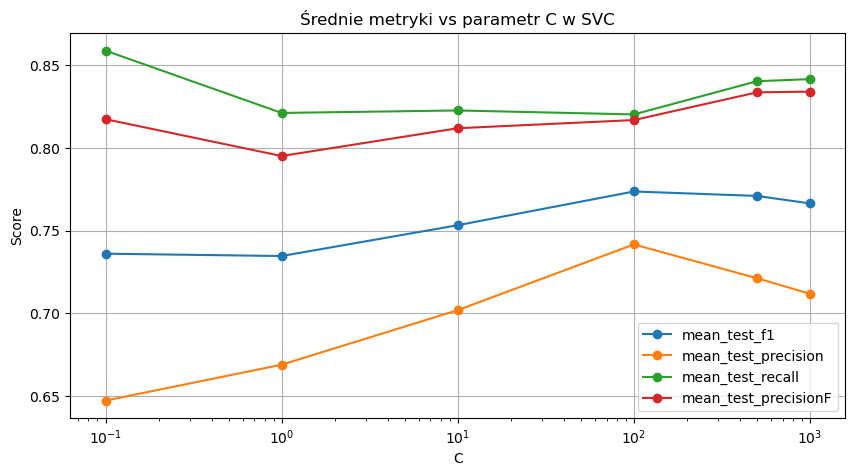

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# wyniki z RandomizedSearchCV
results = pd.DataFrame(search_svc.cv_results_)

# lista metryk dostępnych w wynikach
metrics = [m for m in ["mean_test_f1", "mean_test_precision", "mean_test_recall", "mean_test_precisionF"]
           if m in results.columns]

# wybieramy parametr do osi X
param_to_plot = "param_C"

# średnia metryk po wartościach parametru (C)
plot_data = results.groupby(param_to_plot)[metrics].mean().sort_index()

# wykres
plt.figure(figsize=(10, 5))
for metric in metrics:
    plt.plot(plot_data.index, plot_data[metric], marker='o', label=metric)

plt.xlabel("C")
plt.ylabel("Score")
plt.title("Średnie metryki vs parametr C w SVC")
plt.legend()
plt.grid(True)
plt.xscale("log")  # ponieważ C zwykle w log skali
plt.show()

Now let's try to combine them bo voting classifier

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Załóżmy, że masz już gotowe modele:
# rf = RandomForestClassifier(...)
# svc = Pipeline([...])  # SVC w pipeline ze skalowaniem

voting_clf = VotingClassifier(
    estimators=[
        ('rf', optimal_rf),
        ('svc', optimal_svc)
    ],
    voting='soft'  # potrzebne, żeby działały wagi
)

# Parametry do strojenia: tylko wagi
param_grid = {
    'weights': [
        [1, 1],
        [2, 1],
        [1, 2],
        [3, 1],
        [1, 3],
        [4, 1],
        [5, 1],
    ]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='precision',  # najlepszy model wg F1
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best weights:", grid_search.best_params_['weights'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .....................................weights=[2, 1]; total time=  18.8s
[CV] END .....................................weights=[1, 1]; total time=  19.0s
[CV] END .....................................weights=[2, 1]; total time=  19.5s
[CV] END .....................................weights=[1, 1]; total time=  19.7s
[CV] END .....................................weights=[1, 1]; total time=  19.9s
[CV] END .....................................weights=[1, 1]; total time=  21.6s
[CV] END .....................................weights=[2, 1]; total time=  21.7s
[CV] END .....................................weights=[1, 1]; total time=  23.9s
[CV] END .....................................weights=[1, 2]; total time=  20.6s
[CV] END .....................................weights=[2, 1]; total time=  21.6s
[CV] END .....................................weights=[1, 2]; total time=  21.9s
[CV] END .....................................wei

In [6]:
optimal_voting_rf_svc = grid_search.best_estimator_
print(results[["params", "mean_test_f1", "mean_test_precision", "mean_test_recall"]])
from sklearn.metrics import confusion_matrix
best_cm = confusion_matrix(y_test, optimal_voting_rf_svc.predict(X_test))
tree_cm = confusion_matrix(y_test, optimal_rf.predict(X_test))
print("Macierz pomyłek voting:\n", best_cm)
print("Macierz pomyłek randForest:\n", best_cm)


                                               params  mean_test_f1  \
0   {'kernel': 'linear', 'gamma': 'scale', 'degree...      0.735190   
1   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.766522   
2   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.734717   
3   {'kernel': 'linear', 'gamma': 'scale', 'degree...      0.735190   
4   {'kernel': 'linear', 'gamma': 'scale', 'degree...      0.760335   
5   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.766673   
6   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.735190   
7   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.760335   
8   {'kernel': 'linear', 'gamma': 'scale', 'degree...      0.734717   
9   {'kernel': 'linear', 'gamma': 'auto', 'degree'...      0.766673   
10  {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4...      0.773776   
11  {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3...      0.747105   
12  {'kernel': 'rbf', 'gamma': 'scale', 'degree': ...      0.737533   
13  {'

Now we'll try tu dumb everything to files and try to work with thresholds on a new file

In [7]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import joblib

joblib.dump(optimal_rf, "../../saved-models/merged/optimal_rf.pkl")
joblib.dump(optimal_svc, "../../saved-models/merged/optimal_svc.pkl")
joblib.dump(optimal_voting_rf_svc, "../../saved-models/merged/optimal_voting_rf_svc.pkl")

['../../saved-models/merged/optimal_voting_rf_svc.pkl']